In [ ]:
# !pip uninstall httpx
!pip install --upgrade openai
!pip install httpx==0.27.2
!pip install langchain mistralai requests
!pip install langchain_openai google-search-results langchain
!pip install -U langchain-community
!pip install langchain-core
!pip install langchain_mistralai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.3/390.3 kB 6.7 MB/s eta 0:00:00
  Attempting uninstall: openai
    Found existing installation: openai 1.54.5
    Uninstalling openai-1.54.5:
      Successfully uninstalled openai-1.54.5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 2.1 MB/s eta 0:00:00
  Attempting uninstall: httpx
    Found existing installation: httpx 0.28.1
    Uninstalling httpx-0.28.1:
      Successfully uninstalled httpx-0.28.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.0/260.0 kB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 18.8 MB/s eta 0:00:00
  Created wheel for google-search-results: filename=google_search_results-2.4.2-py3-none-any.whl size=32009 sha256=2c9b426bd6eeddd59c7706189fb3c18b340560f97feca93c924f726813d9747d
  Stored in directory: /root/.cache/pip/wheels/d3/b2/c3/03302d12bb44a2cdff3c9371

In [ ]:
import json
import os
import time
import re
import requests
import urllib.request
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from langchain.chat_models import ChatOpenAI
from langchain.schema import HumanMessage
from langchain.prompts import PromptTemplate
from langchain.llms import OpenAI
from langchain_mistralai import ChatMistralAI
from langchain_core.prompts import ChatPromptTemplate
from google.colab import userdata

import openai
from openai import OpenAI

In [ ]:
openai_api_key = userdata.get('OPENAI_API_KEY')
mistral_api_key = userdata.get('MISTRAL_API_KEY')
rapidapi_key = userdata.get('RAPIDAPI_KEY')

print("API keys loaded successfully!")

client = openai.OpenAI(api_key=openai_api_key)

API keys loaded successfully!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
def json_print(data):
    """Pretty print JSON data"""
    print(json.dumps(data, indent=2))

In [ ]:
def load_json_data():
    """Load JSON data from remote URLs."""
    spec_url = "/content/drive/MyDrive/E6998-Project/nestful_data_json/kinetiq-executable-spec.json"
    # data_url = "https://github.com/IBM/NESTFUL/raw/main/data/executable/executable-data.json"

    with urllib.request.urlopen(spec_url) as spec_resp:
        exec_spec = json.load(spec_resp)

    with urllib.request.urlopen(data_url) as data_resp:
        exec_data = json.load(data_resp)

    # Extract the first index as the test case
    exec_spec_0 = exec_spec[0]
    exec_data_0 = exec_data[0]

    print("Loaded JSON data and extracted the first index.")
    return exec_spec, exec_data, exec_spec_0, exec_data_0

In [ ]:
def convert_spec_to_dict(input_file, output_file):
    with open(input_file, 'r') as f:
        data = json.load(f)

    output_dict = {}
    for item in data:
        if 'name' not in item:
            print(f"Warning: Item missing 'name' field: {item}")
            continue

        name = item['name']
        if name in output_dict:
            raise ValueError(f"Error: Duplicate key '{name}' found in the JSON data.")
        output_dict[name] = item

    try:
        with open(output_file, 'w') as f:
            json.dump(output_dict, f, indent=2)
        print(f"Successfully converted JSON to dictionary and saved to '{output_file}'.")

    except Exception as e:
        print(f"Error saving to file: {e}")


input_file_path = "/content/drive/MyDrive/E6998-Project/nestful_data_json/kinetiq-executable-spec.json"
output_file_path = "/content/drive/MyDrive/E6998-Project/nestful_data_json/kinetiq-executable-spec-dict.json"

# convert_spec_to_dict(input_file_path, output_file_path)

In [ ]:
# Function to transform the data
input_file_path = "/content/drive/MyDrive/E6998-Project/nestful_data_json/kinetiq-executable-spec.json"
output_file_path = "/content/drive/MyDrive/E6998-Project/nestful_data_json/kinetiq-ground-truths-template.json"

def create_ground_truth_data(input_file, output_file):
    # Load the input JSON file
    with open(input_file, "r") as file:
        data = json.load(file)

    # Create a new transformed list
    transformed_data = []

    for obj in data:
        # Copy over the specified keys
        new_obj = {
            "name": obj.get("name", ""),
            "host": obj.get("host", ""),
            "url": obj.get("url", ""),
            "endpoint": obj.get("endpoint", ""),
            "query_parameters": {key: "" for key in obj.get("query_parameters", {}).keys()},
            "llm_query": ""
        }
        transformed_data.append(new_obj)

    # Save the transformed data back to a JSON file
    with open(output_file, "w") as outfile:
        json.dump(transformed_data, outfile, indent=4)

    print(f"Transformed data saved to: {output_file}")

# Run the function
# create_ground_truth_data(input_file_path, output_file_path)

In [ ]:
def make_api_call(query_string, api_url, host):
  # https://www.weatherapi.com/docs/#apis-s

  headers = {
    "x-rapidapi-key": rapidapi_key,
    "x-rapidapi-host": host
  }

  response = requests.get(api_url, headers=headers, params=query_string)
  print("host ", host, " response code ", response.status_code)
  return response.json(), response.status_code, query_string

In [ ]:
query_string = {"q":"London","days":"1","aqi":"yes"}
api_url = "https://weatherapi-com.p.rapidapi.com/forecast.json"
host = "weatherapi-com.p.rapidapi.com"
gt_test, gtp_code, gtp_test = make_api_call(query_string, api_url, host)

host  weatherapi-com.p.rapidapi.com  response code  200


In [ ]:
def make_llm_api_call(api_name, api_url, query, llm_type, schema):
  llm = None
  if llm_type == "mistral":
    llm = ChatMistralAI(
        model="mistral-large-latest",
        mistral_api_key=mistral_api_key,
        temperature=0,
        max_retries=2,
      )
  elif llm_type == "gpt-3.5":
    llm = ChatOpenAI(model="gpt-3.5-turbo", openai_api_key=openai_api_key)
  elif llm_type == "gpt-4o":
    llm = ChatOpenAI(model="gpt-4o", openai_api_key=openai_api_key)

  schema_info = ""
  if schema:
    required_keys = [k for k, v in schema["query_parameters"].items() if v["required"]]
    optional_keys = [k for k, v in schema["query_parameters"].items() if not v["required"]]

    schema_info = f"""These are a list of the required parameters {required_keys} and optional parameters {optional_keys}"""

  schema_prompt = f"""
      Given the following api {api_url} and the query {query} to use to determine
      what parameters need to be set in the API call. {schema_info}.

      Return the parameters you would need to make this API call in a response as a dictionary of API query parameters. Ensure keys and values are proper strings.
      Do not include anything else such as comments (#).
      Only return this dictionary as your result and nothing else as I want to easily extract this object from your response.
      """
  prompt = ChatPromptTemplate.from_messages(
      [
      (
          "system",
          "You are a helpful assistant that creates an API call user request.",
      ),
      ("human", schema_prompt),
      ]
  )

  chain = prompt | llm
  result = chain.invoke(
      {
          "api": api_url,
          "query":query,
          # "schema": escaped_params,
      }
  )

  if result.content:
    print("DEBUG:", result.content)
    generated_params = result.content
    if '`' in generated_params:
      cleaned_response = result.content.strip('`').replace('json\n', '')
      print("DEBUG:", cleaned_response)
      generated_params = json.loads(cleaned_response)
  else:
    print("Error getting response!")
    return {"error": "Failed to generate API call"}

  return generated_params

In [ ]:
# Evaluate responses
def evaluate_responses(ground_truth_params, generated_response_params, llm_type):
    """Evaluate the responses using OpenAI GPT-3.5."""
    evaluator = None
    if llm_type == "mistral":
      evaluator = ChatMistralAI(
          model="mistral-large-latest",
          mistral_api_key=mistral_api_key,
          temperature=0,
          max_retries=2,
        )
    elif llm_type == "gpt-3.5":
      evaluator = ChatOpenAI(model="gpt-3.5-turbo", openai_api_key=openai_api_key)
    elif llm_type == "gpt-4o":
      evaluator = ChatOpenAI(model="gpt-4o", openai_api_key=openai_api_key)

    # Construct evaluation prompt
    eval_prompt = PromptTemplate(
        input_variables=["ground_truth_params", "generated_response_params"],
        template="""
        Compare the following two API query parameters and return the calculated accuracy score (using the calculation in the instructions) within brackets {{}} e.g. {{50.0%}} or {{100%}}:

        Ground Truth Response:
        {ground_truth_params}

        Generated Response:
        {generated_response_params}

        Instructions:
        - Check if the two responses are identical.
        - If identical, return a score of 100%.
        - If not, calculate the accuracy of the generated response as follows:
        -- accuracy = 100 - [100 * [0.7 * (# of parameters that exist in ground_truth_params but not generated_response_params / total # of parameters in ground_truth_params) +
                     0.3 * (# of parameters that exist in generated_response_params and not ground_truth_params / total # of parameters in ground_truth_params)]]
        - Return a summary score and justification.
        - You MUST return only the final accuracy score inside brackets {{}} regardless of what the score is, e.g. {{50.0}} or {{100}}
        """
    )

    chain = eval_prompt | evaluator

    result = chain.invoke({
        "ground_truth_params": ground_truth_params,
        "generated_response_params": generated_response_params,
    })

    return result.content

In [ ]:
def calculate_accuracy(ground_truth_params, generated_response_params):

  # Replace single quotes with double quotes
  if type(generated_response_params) == str:
      cleaned_response = generated_response_params.replace("'", '"')
      cleaned_generated_response_params = json.loads(cleaned_response)
  else:
      cleaned_generated_response_params = generated_response_params
  # Convert dictionaries into sets of keys
  ground_truth_keys = set(ground_truth_params.keys())
  generated_response_keys = set(cleaned_generated_response_params.keys())

  # Calculate missing parameters (in ground_truth but not in generated_response)
  missing_params = ground_truth_keys - generated_response_keys

  # Calculate extra parameters (in generated_response but not in ground_truth)
  extra_params = generated_response_keys - ground_truth_keys

  # Total parameters in ground_truth
  total_params = len(ground_truth_keys)

  # Avoid division by zero
  if total_params == 0:
      return 100.0

  # Calculate the accuracy using the formula
  accuracy = 100 - (100 *((0.7 * (len(missing_params) / total_params)) +
                    (0.3 * (len(extra_params) / total_params))))

  return accuracy

In [ ]:
ground_truths_file = "/content/drive/MyDrive/E6998-Project/nestful_data_json/kinetiq-ground-truths.json"
specs_dict = "/content/drive/MyDrive/E6998-Project/nestful_data_json/kinetiq-executable-spec-dict.json"

def run_api_calls(ground_truths_file, specs_dict, llm_type, use_schema):

  llm_accuracies = []
  calc_accuracies = []
  qs_gen_eval_times = []
  with open(ground_truths_file, "r") as file:
    ground_truths = json.load(file)

  with open(specs_dict, "r") as file:
    api_specs = json.load(file)

  api_responses = []
  llm_responses = []
  eval_times = []

  for obj in ground_truths:

    api_name = obj.get("name", "")

    query_str = obj.get("query_parameters", {})
    host = obj.get("host", "")
    endpoint = obj.get("endpoint", "")
    llm_query = obj.get("llm_query", "")

    api_url = "https://" + host + endpoint
    print("API: {}, Url: {}".format(api_name, api_url))

    # check that the query parameters are valid
    resp, code, qs = make_api_call(query_str, api_url, host)
    api_responses.append(resp)

    if code != 200:
      print("API call failed for ", api_name, " , check the request.")
    if code == 200:
      print("API call succeeded -- ground truth query parameters are valid!")

    if api_name in api_specs:
        print("Found API spec!")

    print("Passing in LLM query: ", llm_query)

    if use_schema:
      spec = api_specs[api_name]
      start_time = time.time()
      generated_params = make_llm_api_call(api_name, api_url, llm_query, llm_type, spec)
      end_time = time.time()
      eval_time = end_time - start_time
    else:
      start_time = time.time()
      generated_params = make_llm_api_call(api_name, api_url, llm_query, llm_type, {})
      end_time = time.time()

    qs_gen_eval_time = end_time - start_time
    qs_gen_eval_times.append(qs_gen_eval_time)

    llm_responses.append(generated_params)

    print("Generated params: ", generated_params)
    print("Ground Truth params: ", query_str)

    scored_result = calculate_accuracy(query_str, generated_params)
    start_time = time.time()
    llm_eval_result = evaluate_responses(query_str, generated_params, llm_type)
    end_time = time.time()
    eval_time = end_time - start_time
    eval_times.append(eval_time)
    print("Evaluation time: ", eval_time)

    print("LLM-as-a-judge accuracy score:", llm_eval_result)
    print("Function calculated accuracy score:", scored_result)

    # llm_accuracy = llm_eval_result.split("{{")[1].split("}}")[0]
    pattern = r"\{(.*?)\}"
    llm_accuracy = re.findall(pattern, llm_eval_result)
    print("DEBUG llm_accuracy", llm_accuracy)
    llm_accuracies.append(llm_accuracy)
    calc_accuracies.append(scored_result)

    time.sleep(5)

  api_resp_outfile = "/content/drive/MyDrive/E6998-Project/results/" + llm_type + "_schema_" + str(use_schema)+ "_api_responses2.json"
  llm_acc_outfile = "/content/drive/MyDrive/E6998-Project/results/"+ llm_type + "_schema_" + str(use_schema)+ "_llm_eval_accuracies2.json"
  calc_acc_outfile = "/content/drive/MyDrive/E6998-Project/results/"+ llm_type + "_schema_" + str(use_schema)+ "_calc_accuracies2.json"
  llm_resp_outfile = "/content/drive/MyDrive/E6998-Project/results/"+ llm_type + "_schema_" + str(use_schema)+ "_llm_responses2.json"
  llm_eval_times_outfile = "/content/drive/MyDrive/E6998-Project/results/"+ llm_type + "_schema_" + str(use_schema)+ "_eval_times2.json"
  llm_qs_eval_times_outfile = "/content/drive/MyDrive/E6998-Project/results/"+ llm_type + "_schema_" + str(use_schema)+ "_eval_times2.json"

  with open(api_resp_outfile, "w") as outfile:
    json.dump(api_responses, outfile, indent=4)

  with open(llm_acc_outfile, "w") as outfile:
    json.dump(llm_accuracies, outfile, indent=4)

  with open(llm_resp_outfile, "w") as outfile:
    json.dump(llm_responses, outfile, indent=4)

  with open(calc_acc_outfile, "w") as outfile:
    json.dump(calc_accuracies, outfile, indent=4)

  with open(llm_eval_times_outfile, "w") as outfile:
    json.dump(eval_times, outfile, indent=4)

  with open(llm_qs_eval_times_outfile, "w") as outfile:
    json.dump(qs_gen_eval_times, outfile, indent=4)

  return llm_accuracies, calc_accuracies, llm_responses

## Experiment 1: Mistral (with Spec)

---



In [ ]:
mistral_schema_true_llm_accuracies, mistral_schema_true_calc_accuracies, mistral_schema_true_llm_responses = run_api_calls(ground_truths_file, specs_dict, "mistral", True)

API: WeatherAPI.com_Forecast_Weather_API, Url: https://weatherapi-com.p.rapidapi.com/forecast.json
host  weatherapi-com.p.rapidapi.com  response code  200
API call succeeded -- ground truth query parameters are valid!
Found API spec!
Passing in LLM query:  What's the weather in London today? I don't know if I can go out this afternoon with my allergies, they get bad with the air quality
DEBUG: ```json
{
  "q": "London",
  "days": "1",
  "aqi": "yes"
}
```
DEBUG: {
  "q": "London",
  "days": "1",
  "aqi": "yes"
}

Generated params:  {'q': 'London', 'days': '1', 'aqi': 'yes'}
Ground Truth params:  {'q': 'London', 'days': '1', 'aqi': 'yes'}
Evaluation time:  0.6918566226959229
LLM-as-a-judge accuracy score: The two API query parameters are identical, so the accuracy score is 100% {100%}. This means that the generated response matches the ground truth response completely.
Function calculated accuracy score: 100.0
DEBUG llm_accuracy ['100%']
API: Booking.com_Flights_API, Url: https://bookin

In [ ]:
mistral_schema_true_llm_accuracies, mistral_schema_true_calc_accuracies, mistral_schema_true_llm_responses = run_api_calls(ground_truths_file, specs_dict, "mistral", True)

API: WeatherAPI.com_Forecast_Weather_API, Url: https://weatherapi-com.p.rapidapi.com/forecast.json
host  weatherapi-com.p.rapidapi.com  response code  200
API call succeeded -- ground truth query parameters are valid!
Found API spec!
Passing in LLM query:  What's the weather in London today? I don't know if I can go out this afternoon with my allergies, they get bad with the air quality
DEBUG: {"q":"London","days":"1","aqi":"yes"}
Generated params:  {"q":"London","days":"1","aqi":"yes"}
Ground Truth params:  {'q': 'London', 'days': '1', 'aqi': 'yes'}


HTTPStatusError: Error response 429 while fetching https://api.mistral.ai/v1/chat/completions: {"message":"Requests rate limit exceeded"}

## Experiment 2: Mistral (without Spec)


---




In [ ]:
mistral_schema_false_llm_accuracies, mistral_schema_false_calc_accuracies, mistral_schema_false_llm_responses = run_api_calls(ground_truths_file, specs_dict, "mistral", False)

API: WeatherAPI.com_Forecast_Weather_API, Url: https://weatherapi-com.p.rapidapi.com/forecast.json
host  weatherapi-com.p.rapidapi.com  response code  200
API call succeeded -- ground truth query parameters are valid!
Found API spec!
Passing in LLM query:  What's the weather in London today? I don't know if I can go out this afternoon with my allergies, they get bad with the air quality
DEBUG: {"q":"London","days":"1","aqi":"yes"}
Generated params:  {"q":"London","days":"1","aqi":"yes"}
Ground Truth params:  {'q': 'London', 'days': '1', 'aqi': 'yes'}
Evaluation time:  0.8128905296325684
LLM-as-a-judge accuracy score: The ground truth response and generated response have identical parameters, so the accuracy score is 100% {100%}. This means that the generated response perfectly matches the ground truth response.
Function calculated accuracy score: 100.0
DEBUG llm_accuracy ['100%']
API: Booking.com_Flights_API, Url: https://booking-com15.p.rapidapi.com/searchFlights.json
host  booking-co

## Experiment 3: GPT 3.5 (with Spec)


---




In [ ]:
gpt3_5_schema_true_llm_accuracies, gpt3_5_schema_true_calc_accuracies, gpt3_5_schema_true_llm_responses = run_api_calls(ground_truths_file, specs_dict, "gpt-3.5", True)

API: WeatherAPI.com_Forecast_Weather_API, Url: https://weatherapi-com.p.rapidapi.com/forecast.json
host  weatherapi-com.p.rapidapi.com  response code  200
API call succeeded -- ground truth query parameters are valid!
Found API spec!
Passing in LLM query:  What's the weather in London today? I don't know if I can go out this afternoon with my allergies, they get bad with the air quality
DEBUG: {
    "q": "London",
    "aqi": "yes"
}
Generated params:  {
    "q": "London",
    "aqi": "yes"
}
Ground Truth params:  {'q': 'London', 'days': '1', 'aqi': 'yes'}
Evaluation time:  1.562256097793579
LLM-as-a-judge accuracy score: The ground truth response has 3 parameters: {'q', 'days', 'aqi'}
The generated response has 2 parameters: {'q', 'aqi'}

Calculating the accuracy score:
accuracy = 100 - [100 * [0.7 * (1/3) + 0.3 * (0/3)]]
accuracy = 100 - [100 * [0.7 * 0.333 + 0.3 * 0]]
accuracy = 100 - [100 * 0.233]
accuracy = 100 - 23.3
accuracy = 76.7%

Therefore, the accuracy score is {76.7%} as the

In [ ]:
gpt3_5_schema_true_llm_accuracies, gpt3_5_schema_true_calc_accuracies, gpt3_5_schema_true_llm_responses = run_api_calls(ground_truths_file, specs_dict, "gpt-3.5", True)

API: WeatherAPI.com_Forecast_Weather_API, Url: https://weatherapi-com.p.rapidapi.com/forecast.json
host  weatherapi-com.p.rapidapi.com  response code  200
API call succeeded -- ground truth query parameters are valid!
Found API spec!
Passing in LLM query:  What's the weather in London today? I don't know if I can go out this afternoon with my allergies, they get bad with the air quality
DEBUG: {
    "q": "London",
    "aqi": "yes"
}
Generated params:  {
    "q": "London",
    "aqi": "yes"
}
Ground Truth params:  {'q': 'London', 'days': '1', 'aqi': 'yes'}
Evaluation time:  1.725449562072754
LLM-as-a-judge accuracy score: The ground truth response has 3 parameters: 'q', 'days', 'aqi'
The generated response has 2 parameters: 'q', 'aqi'

Calculating accuracy:
accuracy = 100 - [100 * [0.7 * (1 / 3) + 0.3 * (0 / 3)]]
accuracy = 100 - [100 * [0.7 * 0.333 + 0.3 * 0]]
accuracy = 100 - [100 * 0.233]
accuracy = 100 - 23.3
accuracy = 76.7

Therefore, the accuracy score is {76.7} as the generated r

## Experiment 4: GPT 3.5 (without Spec)


---




In [ ]:
gpt3_5_schema_false_llm_accuracies, gpt3_5_schema_false_calc_accuracies, gpt3_5_schema_false_llm_responses = run_api_calls(ground_truths_file, specs_dict, "gpt-3.5", False)

## Experiment 2: GPT 4o (with Spec)


---




In [ ]:
gpt4_schema_true_llm_accuracies, gpt4_schema_true_calc_accuracies, gpt4_schema_true_llm_responses = run_api_calls(ground_truths_file, specs_dict, "gpt-4o", True)

API: WeatherAPI.com_Forecast_Weather_API, Url: https://weatherapi-com.p.rapidapi.com/forecast.json
host  weatherapi-com.p.rapidapi.com  response code  200
API call succeeded -- ground truth query parameters are valid!
Found API spec!
Passing in LLM query:  What's the weather in London today? I don't know if I can go out this afternoon with my allergies, they get bad with the air quality
DEBUG: {"q": "London", "days": "1", "aqi": "yes"}
Generated params:  {"q": "London", "days": "1", "aqi": "yes"}
Ground Truth params:  {'q': 'London', 'days': '1', 'aqi': 'yes'}
Evaluation time:  0.7784361839294434
LLM-as-a-judge accuracy score: The ground truth response and generated response have the same parameters, so the accuracy score is 100% {100%}.
Function calculated accuracy score: 100.0
DEBUG llm_accuracy ['100%']
API: Booking.com_Flights_API, Url: https://booking-com15.p.rapidapi.com/searchFlights.json
host  booking-com15.p.rapidapi.com  response code  404
API call failed for  Booking.com_Fli

In [ ]:
gpt4_schema_true_llm_accuracies, gpt4_schema_true_calc_accuracies, gpt4_schema_true_llm_responses = run_api_calls(ground_truths_file, specs_dict, "gpt-4o", True)

## Experiment 2: GPT 4o (without Spec)


---




In [ ]:
gpt4_schema_false_llm_accuracies, gpt4_schema_false_calc_accuracies, gpt4_schema_false_llm_responses = run_api_calls(ground_truths_file, specs_dict, "gpt-4o", False)

# Results


---





In [ ]:
def clean_scores(scores):
  cleaned_scores = []
  for item in scores:
    if '%' in item:
      cleaned = item.replace('%', '')
    else:
      cleaned = item
    cleaned_scores.append(float(cleaned))

  return cleaned_scores

In [ ]:
def plot_scores(llm_type, use_schema):
  llm_acc_outfile = "/content/drive/MyDrive/E6998-Project/results/"+ llm_type + "_schema_" + str(use_schema)+ "_llm_eval_accuracies.json"
  calc_acc_outfile = "/content/drive/MyDrive/E6998-Project/results/"+ llm_type + "_schema_" + str(use_schema)+ "_calc_accuracies.json"
  llm_eval_times_outfile = "/content/drive/MyDrive/E6998-Project/results/"+ llm_type + "_schema_" + str(use_schema)+ "_eval_times.json"

  api_dict = {}

  with open(llm_acc_outfile, "r") as file:
    llm_acc = json.load(file)
    llm_eval_acc = [acc[0] for acc in llm_acc]

  with open(calc_acc_outfile, "r") as file:
    calc_acc = json.load(file)

  with open(llm_eval_times_outfile, "r") as file:
    eval_times = json.load(file)

  with open(ground_truths_file, "r") as file:
    ground_truths = json.load(file)

  print(llm_eval_acc)
  print(calc_acc)
  print(eval_times)

  cleaned_llm_eval_acc = clean_scores(llm_eval_acc)

  df = pd.DataFrame({'LLM-as-a-judge accuracy': cleaned_llm_eval_acc, 'Computed accuracy': calc_acc, 'Judging eval Time': eval_times})

  x_range = list(range(0, len(df)))
  y_range = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110]
  sns.set(style="whitegrid")
  plt.figure(figsize=(10, 5))
  plt.tight_layout()

  # plt.scatter(llm_eval_acc)
  sns.scatterplot(x=df.index, y=df['Computed accuracy'], marker='o', s=100, label='Computed accuracy', color='C0')

  # Plot col2 with x marker and smaller size
  sns.scatterplot(x=df.index, y=df['LLM-as-a-judge accuracy'], marker='x', s=200, label='LLM-as-a-judge accuracy', color='red')

  plt.xticks(x_range)
  plt.yticks(y_range)
  plt.xlim(-1, len(calc_acc))
  plt.ylim(0, 105)
  # sns.lineplot(data=eval_times, x="Batch Size", y="Throughput", marker="o")
  plt.title(llm_type+ "-as-a-Judge Accuracy vs. Computed Accuracy")
  plt.xlabel("API Run #")
  plt.ylabel("Accuracies")

  plt.show()

  return df


['100%', '86%', '68%', '65%', '80%', '88.33%', '53.33%', '56.72%', '50%', '50%', '100%', '100%', '100%', '100%', '76.7%', '100%', '100%', '65%', '65%', '65%', '100%', '100%', '100%', '65%', '100%']
[100.0, 86.0, 68.0, 100.0, 80.0, 88.33333333333333, 53.333333333333336, 90.0, 85.0, 100.0, 100.0, 100.0, 100.0, 100.0, 66.66666666666667, 100.0, 100.0, 65.0, 65.0, 65.0, 100.0, 100.0, 100.0, 65.0, 100.0]
[0.6918566226959229, 1.8782753944396973, 1.8713347911834717, 1.6792888641357422, 2.0648345947265625, 1.6371448040008545, 1.4013481140136719, 2.050292730331421, 2.153262138366699, 1.609570026397705, 0.8704357147216797, 0.732867956161499, 1.659381628036499, 1.507197380065918, 1.9373948574066162, 0.6529827117919922, 1.07963228225708, 1.975555658340454, 3.1548666954040527, 1.485499620437622, 0.6294145584106445, 0.8801524639129639, 0.9279320240020752, 1.1229753494262695, 0.8754687309265137]


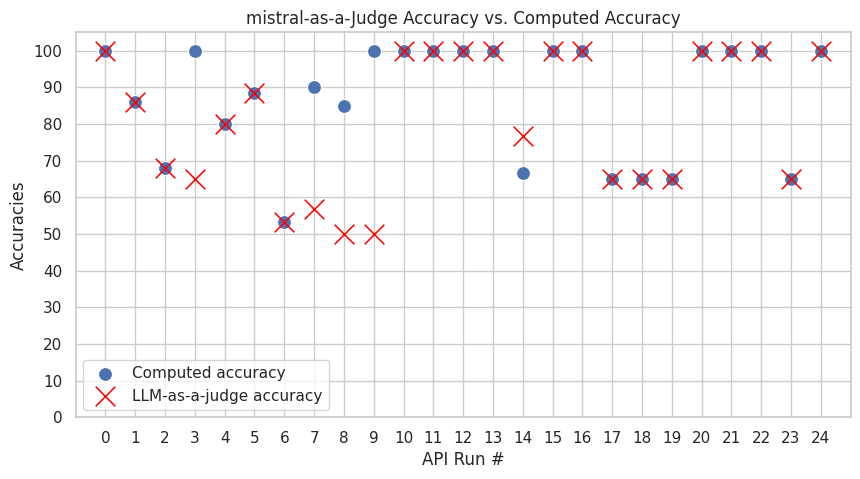

In [ ]:
mistral_schema_true_df = plot_scores("mistral", True)

['76.7', '72', '74', '100', '72', '60', '76.67', '76.67', '65', '100', '82.5', '76.67', '100', '100', '66.67', '76.67', '100', '65', '70', '50', '100', '100', '100', '100', '90']
[76.66666666666667, 72.0, 40.0, 100.0, 72.0, 83.33333333333334, 100.0, 76.66666666666667, 100.0, 100.0, 82.5, 76.66666666666667, 100.0, 100.0, 66.66666666666667, 100.0, 100.0, 65.0, 70.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]
[0.5263636112213135, 0.6326899528503418, 0.8950612545013428, 0.6283111572265625, 0.7297587394714355, 0.8744916915893555, 0.5722723007202148, 0.698967695236206, 0.5965461730957031, 0.613527774810791, 0.6741721630096436, 0.7780299186706543, 0.6054658889770508, 0.5696604251861572, 0.6565759181976318, 0.71396803855896, 0.7277846336364746, 0.6420831680297852, 0.74249267578125, 0.5496819019317627, 0.6572473049163818, 0.6053240299224854, 0.7489519119262695, 0.5656652450561523, 0.5985908508300781]


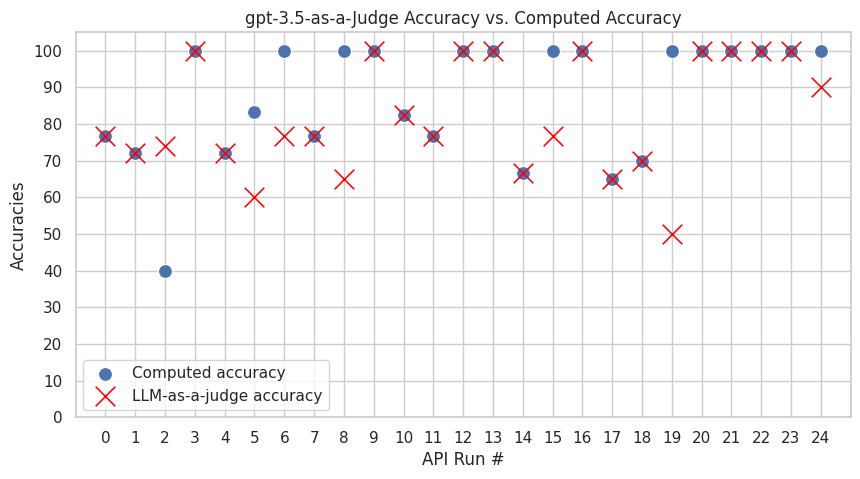

In [ ]:
gpt3_5_schema_true_df = plot_scores("gpt-3.5", True)

['100%', '86%', '68%', '65%', '86%', '86%', '66.7%', '90%', '50%', '65%', '100%', '100%', '90%', '100%', '66.67%', '100%', '65%', '65%', '65%', '65%', '100%', '100%', '100%', '65%', '100%']
[100.0, 86.0, 68.0, 100.0, 80.0, 88.33333333333333, 100.0, 90.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 66.66666666666667, 100.0, 100.0, 65.0, 65.0, 65.0, 100.0, 100.0, 100.0, 65.0, 100.0]
[0.7784361839294434, 1.7098398208618164, 2.3818373680114746, 1.2161469459533691, 1.7517905235290527, 1.5078294277191162, 1.9980666637420654, 3.8962790966033936, 1.520766019821167, 1.5374584197998047, 0.8161427974700928, 1.433502435684204, 1.725682258605957, 1.8283071517944336, 1.4291493892669678, 0.5875318050384521, 1.3440706729888916, 1.14131760597229, 1.7007460594177246, 1.5516178607940674, 0.7808916568756104, 0.8434159755706787, 0.611952543258667, 2.0128490924835205, 0.8720095157623291]


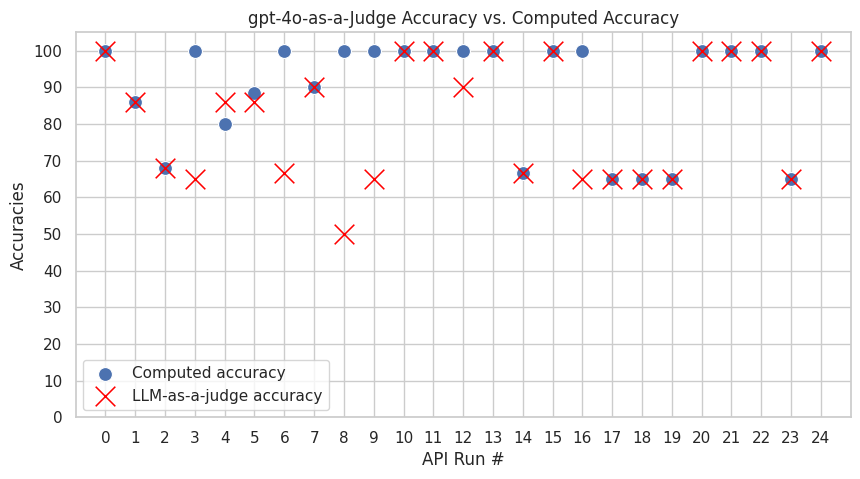

In [ ]:
gpt4o_schema_true_df = plot_scores("gpt-4o", True)

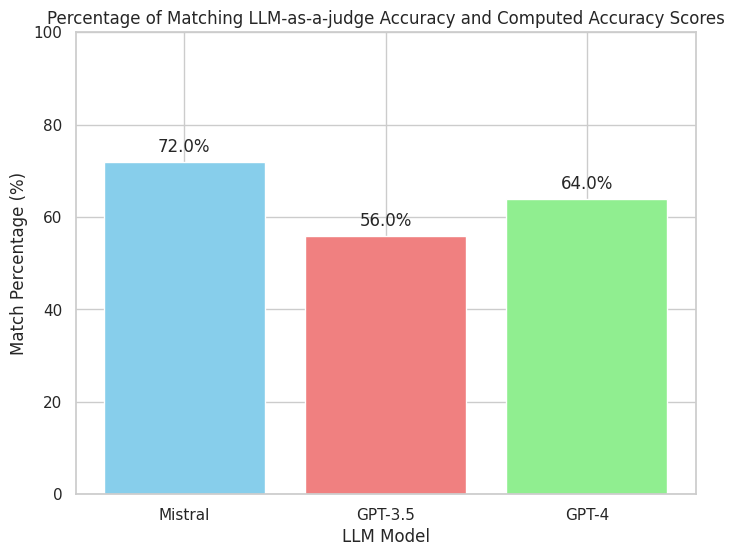

In [ ]:
# prompt: i have 3 dataframes each with 2 columsn. i want to calculate the % of times i see the value for LLM-as-a-judge accuracy col matching the value for Computed accuracy col in the same row for each dataframe. Then i want to plot these 3 as a barchat, use differnet colors

def calculate_match_percentage(df):
  """Calculates the percentage of times LLM and computed accuracy match."""
  return (df['LLM-as-a-judge accuracy'] == df['Computed accuracy']).mean() * 100

# Calculate percentages
mistral_percentage = calculate_match_percentage(mistral_schema_true_df)
gpt3_5_percentage = calculate_match_percentage(gpt3_5_schema_true_df)
gpt4_percentage = calculate_match_percentage(gpt4o_schema_true_df)

# Create a bar chart
models = ['Mistral', 'GPT-3.5', 'GPT-4']
percentages = [mistral_percentage, gpt3_5_percentage, gpt4_percentage]
colors = ['skyblue', 'lightcoral', 'lightgreen']

plt.figure(figsize=(8, 6))
plt.bar(models, percentages, color=colors)
plt.xlabel('LLM Model')
plt.ylabel('Match Percentage (%)')
plt.title('Percentage of Matching LLM-as-a-judge Accuracy and Computed Accuracy Scores')
plt.ylim(0, 100) # Set y-axis limit

for i, v in enumerate(percentages):
    plt.text(i, v + 2, str(round(v, 2)) + '%', ha='center') # Add percentage labels


plt.show()

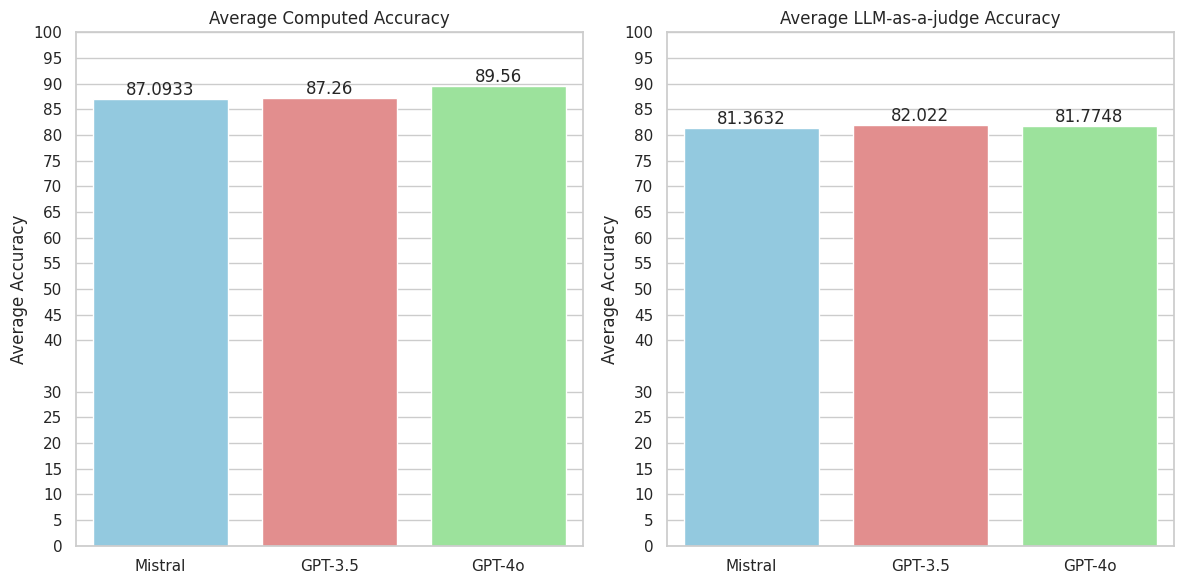

In [ ]:
import warnings
warnings.filterwarnings("ignore")

dfs = [mistral_schema_true_df, gpt3_5_schema_true_df, gpt4o_schema_true_df]
df_names = ['Mistral', 'GPT-3.5', 'GPT-4o']
colors = ['skyblue', 'lightcoral', 'lightgreen']

avg_computed_accuracy = [df['Computed accuracy'].mean() for df in dfs]

avg_llm_accuracy = [df['LLM-as-a-judge accuracy'].mean() for df in dfs]

y_range = [0, 5, 10, 15, 20, 25, 30, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
ax = sns.barplot(x=df_names, y=avg_computed_accuracy, palette=colors)
plt.title('Average Computed Accuracy')
plt.ylabel('Average Accuracy')
plt.yticks(y_range)
for container in ax.containers:
    ax.bar_label(container)

plt.subplot(1, 2, 2)
ax = sns.barplot(x=df_names, y=avg_llm_accuracy, palette=colors)
plt.title('Average LLM-as-a-judge Accuracy')
plt.ylabel('Average Accuracy')
plt.yticks(y_range)
for container in ax.containers:
    ax.bar_label(container)
plt.tight_layout()
plt.show()

# Earlier Examples


---



## Example 1

In [ ]:
make_api_call({
            "ticker": "msft",
            "formtype": "10-q",
            "filingorder": "10"
        }, "https://last10k-company-v1.p.rapidapi.com/v1/company/balancesheet","last10k-company-v1.p.rapidapi.com")

host  last10k-company-v1.p.rapidapi.com  response code  200


({'meta': {'copyright': 'Copyright 2024 Last10K.com All Rights Reserverd',
   'terms': ['https://dev.last10k.com/terms',
    'https://www.sec.gov/privacy.htm#security']},
  'data': {'attributes': {'status': 0,
    'company': {'name': 'MICROSOFT CORP', 'cik': '789019', 'ticker': 'msft'},
    'filing': {'name': 'Balance Sheets',
     'accessionNumber': '0001564590-21-020891',
     'filingDate': '2021-04-27T00:00:00',
     'period': '2021-03-31T00:00:00',
     'formType': '10-Q',
     'filingCount': 0},
    'count': 33,
    'result': {'CashAndCashEquivalentsAtCarryingValue': 13702000000.0,
     'ShortTermInvestments': 111705000000.0,
     'CashCashEquivalentsAndShortTermInvestments': 125407000000.0,
     'AccountsReceivableNetCurrent': 26322000000.0,
     'InventoryNet': 2245000000.0,
     'OtherAssetsCurrent': 11640000000.0,
     'AssetsCurrent': 165614000000.0,
     'PropertyPlantAndEquipmentNet': 54945000000.0,
     'OperatingLeaseRightOfUseAsset': 10673000000.0,
     'LongTermInvestme

In [ ]:
query_string = {"q":"London","days":"1","aqi":"yes"}
api_url = "https://weatherapi-com.p.rapidapi.com/forecast.json"
host = "weatherapi-com.p.rapidapi.com"

all_weather_params = {
    "q" : "required",
    "days" : "required",
    "hour" : "optional",
    "aqi" : "optional",
    "tp" : "optional",
    "lang" : "optional",
}


In [ ]:
ground_truth_res, ground_truth_params = make_api_call(query_string, api_url, host)

In [ ]:
json_print(ground_truth_res)

{
  "location": {
    "name": "London",
    "region": "City of London, Greater London",
    "country": "United Kingdom",
    "lat": 51.5171,
    "lon": -0.1062,
    "tz_id": "Europe/London",
    "localtime_epoch": 1734077583,
    "localtime": "2024-12-13 08:13"
  },
  "current": {
    "last_updated_epoch": 1734076800,
    "last_updated": "2024-12-13 08:00",
    "temp_c": 6.0,
    "temp_f": 42.8,
    "is_day": 1,
    "condition": {
      "text": "Light rain",
      "icon": "//cdn.weatherapi.com/weather/64x64/day/296.png",
      "code": 1183
    },
    "wind_mph": 3.4,
    "wind_kph": 5.4,
    "wind_degree": 108,
    "wind_dir": "ESE",
    "pressure_mb": 1026.0,
    "pressure_in": 30.3,
    "precip_mm": 0.03,
    "precip_in": 0.0,
    "humidity": 100,
    "cloud": 50,
    "feelslike_c": 5.1,
    "feelslike_f": 41.1,
    "windchill_c": 5.5,
    "windchill_f": 41.9,
    "heatindex_c": 6.4,
    "heatindex_f": 43.5,
    "dewpoint_c": 3.2,
    "dewpoint_f": 37.8,
    "vis_km": 4.5,
    "vis_m

In [ ]:
api_endpoint = "https://weatherapi-com.p.rapidapi.com/forecast.json"
api_query = "What's the weather in London today? I don't know if I can go out this afternoon with my allergies, they get bad with the air quality"
mistral_generated_response = make_llm_api_call(api_endpoint, api_query, "mistral", {}, "")

DEBUG: ```json
{
  "q": "London",
  "days": "1",
  "aqi": "yes"
}
```
DEBUG: {
  "q": "London",
  "days": "1",
  "aqi": "yes"
}



In [ ]:
mistral_generated_response

{'q': 'London', 'days': '1', 'aqi': 'yes'}

In [ ]:
chatgpt_generated_response = make_llm_api_call(api_endpoint, api_query, "openai", {}, "")

DEBUG: {
    "query": "London",
    "day": "today"
}


In [ ]:
chatgpt_generated_response

'{\n    "query": "London",\n    "day": "today"\n}'

In [ ]:
evaluation_result = evaluate_responses(ground_truth_params, mistral_generated_response)
print("Evaluation Result:", evaluation_result)

Evaluation Result: The two responses are identical, so the accuracy score is 100%. 
Justification: Both responses have the same query parameters ('q', 'days', 'aqi') with the same values, so the accuracy score is maximum.


In [ ]:
evaluation_result = evaluate_responses(ground_truth_params, chatgpt_generated_response)
print("Evaluation Result:", evaluation_result)

Evaluation Result: The ground truth response has 3 parameters: 'q', 'days', and 'aqi'.
The generated response has 2 parameters: 'query' and 'day'.

Calculating the accuracy:
- Parameters in ground truth but not in generated response: 1 ('days')
- Parameters in generated response but not in ground truth: 2 ('query', 'day')

Accuracy = 100 - [100 * [0.7 * (1/3) + 0.3 * (2/3)]]
Accuracy = 100 - [100 * [0.7 * 0.33 + 0.3 * 0.67]]
Accuracy = 100 - [100 * (0.231 + 0.201)]
Accuracy = 100 - [100 * 0.432]
Accuracy = 100 - 43.2
Accuracy = 56.8%

Therefore, the accuracy of the generated response is 56.8%. The generated response is not identical to the ground truth response.


In [ ]:
chatgpt_weather_actual_acc = calculate_accuracy(ground_truth_params, chatgpt_generated_response)
mistral_weather_actual_acc = calculate_accuracy(ground_truth_params, mistral_generated_response)

print("ChatGPT Weather Actual Accuracy:", chatgpt_weather_actual_acc)
print("Mistral Weather Actual Accuracy:", mistral_weather_actual_acc)

ChatGPT Weather Actual Accuracy: 76.0
Mistral Weather Actual Accuracy: 100.0


## Example 2

In [ ]:
query_string = {"fromId":"JFK.AIRPORT","toId":"STO.AIRPORT","departDate":"2024-12-13","adults":"2", "cabinClass": "ECONOMY"}
api_url = "https://booking-com15.p.rapidapi.com/api/v1/flights/searchFlights"
host = "booking-com15.p.rapidapi.com"
all_params = {
    "fromId" : "required",
    "toId" : "required",
    "departDate" : "required",
    "returnDate" : "optional",
    "pageNo" : "optional",
    "adults" : "optional",
    "children" : "optional",
    "sort" : "optional",
    "cabinClass" : "optional",
    "currency_code" : "optional",
}


In [ ]:
flights_resp, flights_true_params = make_api_call(query_string, api_url, host)
json_print(flights_resp)

{
  "status": true,
  "message": "Success",
  "timestamp": 1734079225021,
  "data": {
    "aggregation": {
      "totalCount": 107,
      "filteredTotalCount": 107,
      "stops": [
        {
          "numberOfStops": 1,
          "count": 53,
          "minPrice": {
            "currencyCode": "USD",
            "units": 1547,
            "nanos": 290000000
          },
          "minPriceRound": {
            "currencyCode": "USD",
            "units": 1548,
            "nanos": 0
          }
        },
        {
          "numberOfStops": 2,
          "count": 107,
          "minPrice": {
            "currencyCode": "USD",
            "units": 752,
            "nanos": 380000000
          },
          "minPriceRound": {
            "currencyCode": "USD",
            "units": 753,
            "nanos": 0
          }
        }
      ],
      "airlines": [
        {
          "name": "Icelandair",
          "logoUrl": "https://r-xx.bstatic.com/data/airlines_logo/FI.png",
          "iat

In [ ]:
flights_true_params

{'fromId': 'JFK.AIRPORT',
 'toId': 'STO.AIRPORT',
 'departDate': '2024-12-13',
 'adults': '2',
 'cabinClass': 'ECONOMY'}

In [ ]:
api_query = "I need an affordable flight for today's date from NYC airport to Stockholm for my husband and I"
additional_info = "Note that the airport code for fromId and toId must be in the format <Airport code in caps>.AIRPORT"
mistral_flights_generated_response = make_llm_api_call(api_url, api_query, "mistral", all_params, additional_info)

DEBUG: ```json
{
  "fromId": "NYC.AIRPORT",
  "toId": "STO.AIRPORT",
  "departDate": "2024-08-07",
  "adults": "2",
  "currency_code": "USD"
}
```
DEBUG: {
  "fromId": "NYC.AIRPORT",
  "toId": "STO.AIRPORT",
  "departDate": "2024-08-07",
  "adults": "2",
  "currency_code": "USD"
}



In [ ]:
mistral_flights_generated_response

{'fromId': 'NYC.AIRPORT',
 'toId': 'STO.AIRPORT',
 'departDate': '2024-08-07',
 'adults': '2',
 'currency_code': 'USD'}

In [ ]:
chatgpt_flights_generated_response = make_llm_api_call(api_url, api_query, "openai", all_params, additional_info)

DEBUG: {
    'fromId': 'NYC.AIRPORT',
    'toId': 'STO.AIRPORT',
    'departDate': 'today'
}


In [ ]:
chatgpt_flights_generated_response


"{\n    'fromId': 'NYC.AIRPORT',\n    'toId': 'STO.AIRPORT',\n    'departDate': 'today'\n}"

In [ ]:
evaluation_result = evaluate_responses(flights_true_params, mistral_flights_generated_response)
print("Evaluation Result:", evaluation_result)

Evaluation Result: Summary:
The two API query parameters are not identical. The generated response is missing the 'fromId' parameter and has an additional 'currency_code' parameter that is not present in the ground truth response. 

Calculation:
Total parameters in ground truth response: 5
Parameters missing in generated response: 1 (fromId)
Parameters additional in generated response: 1 (currency_code)

Accuracy = 100 - [100 * [0.7 * (1/5) + 0.3 * (1/5)]]
Accuracy = 100 - [100 * (0.7*0.2 + 0.3*0.2)]
Accuracy = 100 - [100 * (0.14 + 0.06)]
Accuracy = 100 - [100 * 0.2]
Accuracy = 100 - 20
Accuracy = 80%

Justification:
The accuracy of the generated response is 80% based on the calculation above. The missing 'fromId' parameter and additional 'currency_code' parameter contribute to the deviation from the ground truth response. Further adjustments may be needed to improve the accuracy of the generated response.


In [ ]:
evaluation_result = evaluate_responses(flights_true_params, chatgpt_flights_generated_response)
print("Evaluation Result:", evaluation_result)

Evaluation Result: The ground truth response and generated response have the following parameters:

Ground Truth Response:
- fromId: JFK.AIRPORT
- toId: STO.AIRPORT
- departDate: 2024-12-13
- adults: 2
- cabinClass: ECONOMY

Generated Response:
- fromId: NYC.AIRPORT
- toId: STO.AIRPORT
- departDate: today

Based on the comparison, we can see that the generated response is missing the 'adults' and 'cabinClass' parameters from the ground truth response. It also replaced the specific departure date with 'today'.

Calculating the accuracy using the provided formula:
- Parameters in ground truth but not in generated response: 2 (adults, cabinClass)
- Parameters in generated response but not in ground truth: 0
- Total number of parameters in ground truth: 5

Accuracy = 100 - [100 * [0.7 * (2/5) + 0.3 * (0/5)]]
Accuracy = 100 - [100 * (0.4 + 0)]
Accuracy = 100 - 40
Accuracy = 60%

Therefore, the accuracy of the generated response is 60%. The summary score is 60% and the justification is that 

In [ ]:
chat_gpt_flights_actual_acc = calculate_accuracy(flights_true_params, chatgpt_flights_generated_response)
mistral_flights_actual_acc = calculate_accuracy(flights_true_params, mistral_flights_generated_response)

print("ChatGPT Flights Actual Accuracy:", chat_gpt_flights_actual_acc)
print("Mistral Flights Actual Accuracy:", mistral_flights_actual_acc)

ChatGPT Flights Actual Accuracy: 72.0
Mistral Flights Actual Accuracy: 80.0
